c:\Users\masak\anaconda3\envs\nanogpt2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


number of parameters: 63.56M


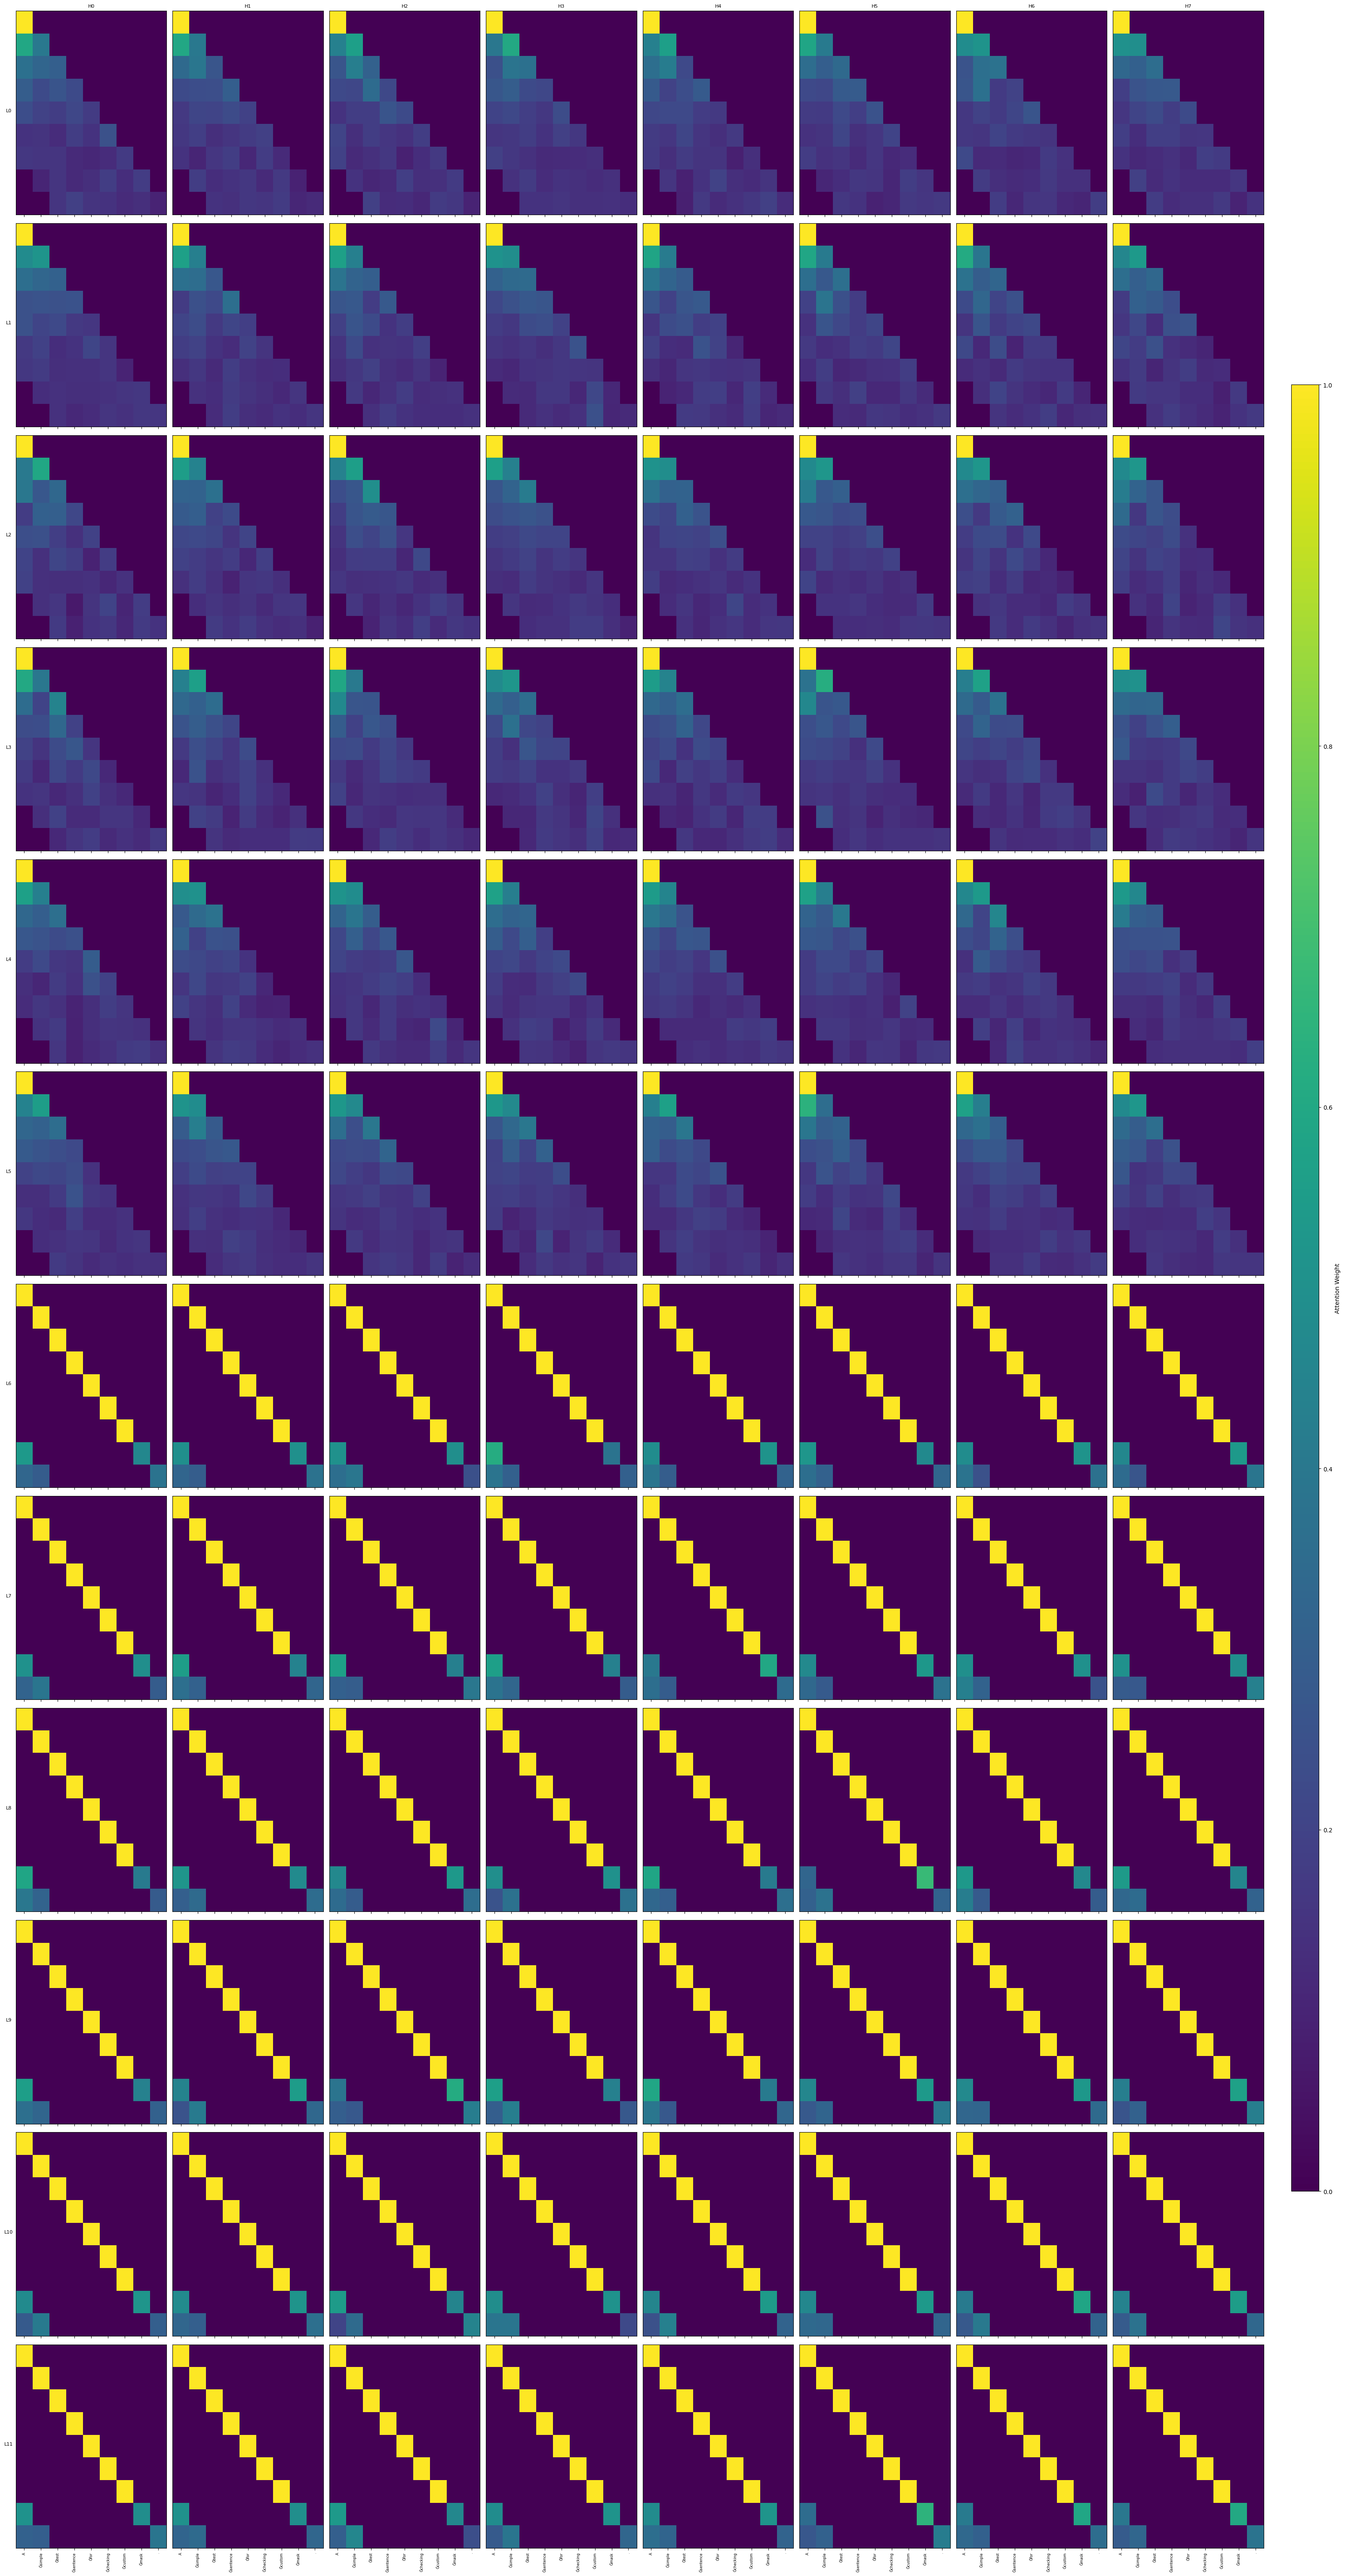

In [1]:
import torch
import matplotlib.pyplot as plt
from transformers import GPT2Tokenizer
from model import GPT, GPTConfig  # あなたの model.py を import
import numpy as np

# 1. モデルロード（flash=True デフォルト）
config = GPTConfig(
    block_size=32, vocab_size=50257,
    n_layer=12, n_head=8, n_embd=512,
    custom_radii=[6]*12, custom_modes=['within']*6+['beyond']*6,
)
model = GPT(config).to('cuda').eval()
# Flash Attention はデフォルト ON

# 2. トークナイズ＆フォワード
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
text = "A simple test sentence for checking custom mask."
ids = tokenizer(text, return_tensors='pt')['input_ids'].to('cuda')
_ = model(ids)   # last_attn が各層で更新される

# 3. attention 重みを集める
all_attns = [blk.attn.last_atten for blk in model.transformer.h]
# all_attns の各要素は (n_head, T, T)

# 4. プロット
n_layer = 12
n_head = 8
tokens = tokenizer.convert_ids_to_tokens(ids[0])

fig, axes = plt.subplots(
    n_layer, n_head,
    figsize=(n_head * 4, n_layer * 5),
    sharex=True, sharey=True
)

# axes を必ず 2 次元配列に reshape
axes = np.array(axes).reshape(n_layer, n_head)

for i in range(n_layer):
    for j in range(n_head):
        ax = axes[i, j]
        im = ax.imshow(all_attns[i][0][j], aspect='auto')
        # 1 行目にヘッド番号
        if i == 0:
            ax.set_title(f'H{j}', fontsize=8)
        # 1 列目にレイヤー番号
        if j == 0:
            ax.set_ylabel(f'L{i}', rotation=0, labelpad=12, fontsize=8)
        # 軸ラベルは最下行・最左列のみ表示
        if i == n_layer - 1:
            ax.set_xticks(range(len(tokens)))
            ax.set_xticklabels(tokens, rotation=90, fontsize=6)
        else:
            ax.set_xticks([])
        if j == 0:
            ax.set_yticks(range(len(tokens)))
            ax.set_yticklabels(tokens, fontsize=6)
        else:
            ax.set_yticks([])

fig.tight_layout()
plt.subplots_adjust(right=0.92)
# カラーバーを追加
cbar_ax = fig.add_axes([0.94, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax, label='Attention Weight')
plt.show()

In [11]:
all_attns[0].shape

torch.Size([1, 8, 9, 64])

In [ ]:
all_attns[0][0]

tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0996,  0.0528,  0.1261,  ..., -0.5509,  0.4239, -0.7653],
         [ 0.0086,  0.2391,  0.3459,  ..., -0.3766,  0.0507, -0.3870]],

        [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.3322,  0.2824, -0.7597,  ..., -0.1226, -0.2141, -0.0219],
         [ 0.1724,  0.1308, -0.0018,  ..., -0.1007, -0.0763, -0.0828]],

        [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0